Some libraries required to execute the code below and pynever classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypoman
import scipy.spatial
import pynever.strategies.abstraction as abst
import pynever.nodes as nodes

A utility function to plot starsets.

In [2]:
def plot_starset(p_starset: abst.StarSet):
    for p_star in p_starset.stars:

        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        x_vertexes = []
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            x_vertexes.append(new_x_v)

        x1_plot = []
        x2_plot = []
        for v in x_vertexes:
            x1_plot.append(v[0, 0])
            x2_plot.append(v[1, 0])

        for k in range(len(x1_plot)):
            for j in range(len(x1_plot)):
                plt.plot([x1_plot[k], x1_plot[j]], [x2_plot[k], x2_plot[j]])

        plt.scatter(x1_plot, x2_plot)
        # plt.fill_between(x1_plot, x2_plot)

    plt.grid()
    plt.show()

A function to compute extreme points in a star (requires <code>pypoman</code> conversion from H-poly to V-poly).

In [3]:
def get_extreme_points(p_starset: abst.StarSet):
    x_vertexes = []
    for p_star in p_starset.stars:
        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
            x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)
    return x_vertexes

A function to plot a convex-hull (requires <code>scipy</code> <code>spatial</code> module to compute the hull from a set of points)

In [4]:
def plot_convex_hull(points: np.ndarray):
    hull = scipy.spatial.ConvexHull(points)
    vertexes = points[hull.vertices, :]
    vertexes = np.vstack((vertexes, vertexes[0, :]))
    plt.plot(vertexes[:, 0], vertexes[:, 1])
    plt.grid()
    plt.show()

Create a simple neural network with three layers. Indeed, these are just the weights and biases of the affine transformations in the fully connected layers. We assume that the activation functions are ReLUs.

In [5]:
# Create the matrices first, then adjust the weights

weight_matrix_1 = np.ones((2, 2))
weight_matrix_2 = np.ones((2, 2))
weight_matrix_3 = np.zeros((2, 2))

weight_matrix_1[1, 1] = -1
weight_matrix_2[1, 1] = -1
weight_matrix_3[0, 0] = 1.0 / 5.0
weight_matrix_3[0, 1] = 1.0 / 5.0
weight_matrix_3[1, 0] = 2

# Create the vectors first, then adjust the biases

bias_1 = np.zeros([2, 1])
bias_2 = np.zeros([2, 1])
bias_3 = np.zeros([2, 1])
bias_3[0, 0] = - 0.4
bias_3[1, 0] = - 2

Use pyNever to build an abstract version of the network. The <code>refiniment_percentage</code> is set to 1, meaning that we are not overapproximating the output set. The parameter <code>neuron_relevance</code> set to <code>True</code> indicates that we consider neuron-level refinement (if any).

In [7]:
refinement_percentage = 1
neuron_relevance = True

abs_net = abst.AbsSeqNetwork("FC_NET_1_1_1_1")

abs_net.add_node(\
                 abst.AbsFullyConnectedNode("AbsFC_1",\
                                            nodes.FullyConnectedNode("FC_1", 2, 2, weight_matrix_1, bias_1)))

abs_net.add_node(\
                 abst.AbsReLUNode("AbsReLU_1",\
                                  nodes.ReLUNode("ReLU_1", 2),\
                                  neuron_relevance = neuron_relevance,\
                                  refinement_percentage = refinement_percentage))
abs_net.add_node(\
                 abst.AbsFullyConnectedNode("AbsFC_2",\
                                            nodes.FullyConnectedNode("FC_2", 2, 2, weight_matrix_2, bias_2)))

abs_net.add_node(\
                 abst.AbsReLUNode("AbsReLU_2",\
                                  nodes.ReLUNode("ReLU_2", 2),
                                  neuron_relevance=neuron_relevance,
                                  refinement_percentage=refinement_percentage))

Now we build an (abstract) input set as a star. This is just the box of intervals in [-1,1].

In [8]:
C = np.zeros((4, 2))
C[0, 0] = 1
C[1, 0] = -1
C[2, 1] = 1
C[3, 1] = -1

d = np.ones((4, 1))
d[0, 0] = 1
d[1, 0] = 1
d[2, 0] = 1
d[3, 0] = 1

star = abst.Star(C, d)
abs_input = abst.StarSet({star})

The following code plots the convex hulls corresponding to the output sets of each layer of the abstract network, given the input star.

Forward ended


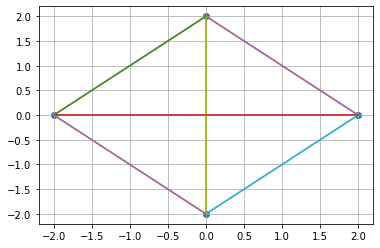

Forward ended


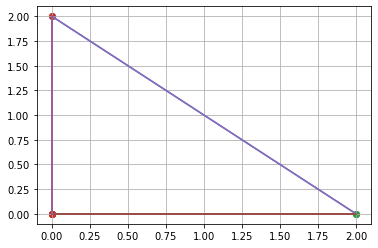

Forward ended


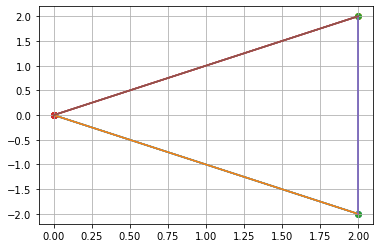

Forward ended


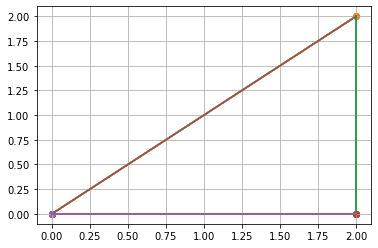

In [9]:
current_node = abs_net.get_first_node()
aux_points = get_extreme_points(abs_input)
while current_node is not None:
    print(current_node)
    abs_input = current_node.forward(abs_input)
    print("Forward ended")
    plot_starset(abs_input)
    current_node = abs_net.get_next_node(current_node)

The last convex hull plotted is the countour of a polytope in which all the points output by the network are guaranteed to lay, as long as the input points lay inside the box defined by the intervals in [-1,1] along each dimension. For instance, if we had to check the property that for all such input the output should avoid the region such that $y_2 > 1$ we could conclude that the property is violated. On the other hand, we can see that the property $y_1 \leq 2$ and $y_2 \leq 2$ is satisfied.